# Human-AI Information Diffusion Simulation with CPC Theory-Based Belief Updates

## Overview

This notebook implements an advanced information diffusion model using Large Language Model (LLM) agents with **Consensus-based Posterior Computation (CPC)** theory for belief updates. Unlike the original implementation, this version strictly follows the mathematical formulation:

$$P(w_d | O^{1:N}, S) = \prod_{k=1}^{N_h+N_a} P(o_d^k | w_d, z_d^k) P(z_d^k | \theta^k) P(w_d | S)$$

Where:
- $w_d$: Candidate representation/belief
- $O^{1:N}$: Set of observations from all agents
- $S$: Safety constraints
- $o_d^k$: Observation from agent k
- $z_d^k$: Latent variable for agent k
- $\theta^k$: Parameters for agent k
- $N_h + N_a$: Total number of human and AI agents

### Key Features

- **CPC-Based Belief Updates**: Rigorous implementation of consensus-based posterior computation
- **Real LLM Integration**: Uses OpenAI GPT or Anthropic Claude APIs for authentic agent responses
- **Network Dynamics**: Agents form connections and influence each other based on interactions
- **Advanced Analytics**: Sentiment analysis, engagement scoring, and network centrality metrics
- **Visualization**: Interactive network graphs and time-series analysis

### Requirements

- Python 3.8+
- PyTorch for tensor operations
- API Key for OpenAI or Anthropic
- Required packages: torch, openai/anthropic, pandas, numpy, matplotlib, seaborn, networkx

### Installation

If you encounter import errors, install/upgrade the required packages:

```bash
pip install torch numpy pandas matplotlib seaborn networkx
pip install openai --upgrade  # For OpenAI API
# pip install anthropic  # For Anthropic API (if using Claude)
```

## 1. Setup and Imports

First, let's import all necessary libraries including PyTorch for CPC computations.

In [11]:
# Core imports
import os
import json
import time
import random
import asyncio
from typing import List, Dict, Optional, Tuple, NamedTuple
from dataclasses import dataclass, field
from datetime import datetime

# Check for required packages
import sys
import importlib

required_packages = {
    'numpy': 'numpy',
    'pandas': 'pandas',
    'torch': 'torch',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'networkx': 'networkx'
}

missing_packages = []
for package, import_name in required_packages.items():
    try:
        importlib.import_module(import_name)
    except ImportError:
        missing_packages.append(package)

if missing_packages:
    print("⚠️  Missing required packages:", ', '.join(missing_packages))
    print(f"Please install them with: pip install {' '.join(missing_packages)}")
    raise ImportError("Missing required packages")

# Scientific computing
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.distributions import Normal, Categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import networkx as nx

# API Options with version compatibility
try:
    # Try new OpenAI library (v1.0+)
    from openai import OpenAI
    OPENAI_V1 = True
except ImportError:
    # Fall back to old OpenAI library
    import openai
    OPENAI_V1 = False
    print("Note: Using older OpenAI library version. Consider upgrading: pip install openai --upgrade")

# from anthropic import Anthropic

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        print("Note: Using default matplotlib style")
        
sns.set_palette("husl")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Verify API key is set
if not os.getenv("OPENAI_API_KEY"):
    print("⚠️  WARNING: OPENAI_API_KEY not found in environment variables")
    print("Please set: export OPENAI_API_KEY='your-key-here'")
else:
    print("✅ API key detected")
    if 'OPENAI_V1' in globals():
        print(f"✅ OpenAI library version: {'v1.0+' if OPENAI_V1 else 'legacy (<v1.0)'}")
    
print("✅ PyTorch available for CPC computations")

⚠️  WARNING: OPENAI_API_KEY not found in environment variables
Please set: export OPENAI_API_KEY='your-key-here'
✅ PyTorch available for CPC computations


## 2. CPC Theory Components

This section implements the core CPC theory components for belief updates.

In [12]:
# CPC Theory Data Structures
@dataclass
class Theta:
    """Agent-specific parameters θ^k"""
    agent_id: str
    expertise_weights: torch.Tensor  # Domain expertise
    confidence: float  # Agent confidence level
    bias_vector: torch.Tensor  # Agent-specific biases
    
@dataclass
class SafetyConfig:
    """Safety constraints configuration"""
    toxicity_threshold: float = 0.1
    controversy_threshold: float = 0.3
    misinformation_penalty: float = 10.0
    safety_dimensions: List[str] = field(default_factory=lambda: 
        ['toxicity', 'controversy', 'accuracy', 'fairness'])

@dataclass
class Belief:
    """Agent belief representation"""
    representation: torch.Tensor  # w_d: belief vector
    confidence: torch.Tensor  # Confidence in belief
    timestamp: datetime
    topic: str

# CPC Helper Functions
def safety_prior_logprob(w_candidates: torch.Tensor, safety_cfg: SafetyConfig) -> torch.Tensor:
    """
    Compute log P(w | S) - the safe prior over candidate representations.
    
    Args:
        w_candidates: [B, D] tensor of candidate belief representations
        safety_cfg: Safety configuration
        
    Returns:
        log_prob: [B] tensor of log probabilities
    """
    B, D = w_candidates.shape
    
    # Compute safety scores for each dimension
    safety_scores = torch.zeros(B)
    
    # Toxicity penalty (assuming first dimension represents toxicity)
    toxicity = torch.sigmoid(w_candidates[:, 0])
    safety_scores -= (toxicity > safety_cfg.toxicity_threshold).float() * safety_cfg.misinformation_penalty
    
    # Controversy penalty (assuming second dimension)
    controversy = torch.sigmoid(w_candidates[:, 1])
    safety_scores -= (controversy > safety_cfg.controversy_threshold).float() * 5.0
    
    # Normalize to valid log probabilities
    log_prob = F.log_softmax(safety_scores, dim=0)
    
    return log_prob

def likelihood_logprob(observation: torch.Tensor, 
                      w_candidates: torch.Tensor, 
                      latent: torch.Tensor) -> torch.Tensor:
    """
    Compute log P(o | w, z) - likelihood of observation given belief and latent.
    
    Args:
        observation: [D] tensor of observed features
        w_candidates: [B, D] tensor of candidate beliefs
        latent: [L] tensor of latent variables
        
    Returns:
        log_lik: [B] tensor of log likelihoods
    """
    B, D = w_candidates.shape
    L = latent.shape[0]
    
    # Transform beliefs through latent variables
    # Create a proper transformation from latent space to belief space
    # Pad latent with zeros to match belief dimension
    if L < D:
        padding = torch.zeros(D - L)
        latent_padded = torch.cat([latent, padding])
        latent_transform = latent_padded.unsqueeze(0).expand(B, -1)
    else:
        # If latent dimension is larger or equal, truncate
        latent_transform = latent[:D].unsqueeze(0).expand(B, -1)
    
    # Apply transformation
    transformed_w = w_candidates + 0.1 * latent_transform
    
    # Compute likelihood as negative squared distance
    # (Gaussian likelihood with fixed variance)
    distances = torch.sum((transformed_w - observation.unsqueeze(0))**2, dim=1)
    log_lik = -0.5 * distances  # Assuming unit variance
    
    return log_lik

def latent_prior_logprob(latent: torch.Tensor, theta: Theta) -> torch.Tensor:
    """
    Compute log P(z | θ) - prior over latent variables given agent parameters.
    
    Args:
        latent: [L] tensor of latent variables
        theta: Agent parameters
        
    Returns:
        log_prob: Scalar log probability
    """
    # Simple Gaussian prior centered at agent bias
    prior_mean = theta.bias_vector[:latent.shape[0]]
    prior_std = theta.confidence
    
    dist = Normal(prior_mean, prior_std)
    log_prob = dist.log_prob(latent).sum()
    
    return log_prob

def cpc_posterior(w_candidates: torch.Tensor,
                  observations: List[torch.Tensor],
                  latents: List[torch.Tensor],
                  thetas: List[Theta],
                  safety_cfg: SafetyConfig) -> torch.Tensor:
    """
    Compute posterior P(w_d | O, S) using CPC theory.
    This is the core belief update mechanism.
    
    Args:
        w_candidates: [B, D] tensor of candidate belief representations
        observations: List of [D] observation tensors from each agent
        latents: List of [L] latent variable tensors for each agent
        thetas: List of agent parameters
        safety_cfg: Safety configuration
        
    Returns:
        posterior: [B] tensor of posterior probabilities P(w_d | O, S)
    """
    # (0) log P(w | S) - safe prior
    log_prior_w = safety_prior_logprob(w_candidates, safety_cfg)  # [B]
    
    # (1) Σ_k log P(o_k | w, z_k) + log P(z_k | θ_k)
    log_joint = log_prior_w.clone()
    
    for o_k, z_k, theta_k in zip(observations, latents, thetas):
        log_lik = likelihood_logprob(o_k, w_candidates, z_k)  # [B]
        log_pz = latent_prior_logprob(z_k, theta_k)  # scalar
        log_joint = log_joint + log_lik + log_pz
    
    # (2) Normalization via log-softmax
    log_posterior = F.log_softmax(log_joint, dim=0)
    posterior = torch.exp(log_posterior)  # [B]
    
    return posterior

print("✅ CPC theory components loaded")

✅ CPC theory components loaded


## 3. Configuration

Configuration for both simulation and CPC parameters.

In [13]:
class Config:
    """Configuration for the simulation"""
    # API Configuration
    API_PROVIDER = "openai"
    OPENAI_MODEL = "gpt-4o"
    
    # Simulation Parameters
    MAX_AGENTS = 10
    MAX_TIME_STEPS = 20
    MESSAGE_WINDOW = 5
    MEMORY_LIMIT = 100
    
    # CPC Parameters
    BELIEF_DIM = 10  # Dimension of belief representation
    LATENT_DIM = 5   # Dimension of latent variables
    N_CANDIDATES = 50  # Number of candidate beliefs to consider
    BELIEF_UPDATE_FREQ = 3  # Update beliefs every N time steps
    
    # Rate Limiting
    API_DELAY = 1.0  # seconds between API calls
    MAX_TOKENS = 100
    
    # Visualization
    FIGURE_SIZE = (12, 8)
    NETWORK_LAYOUT = "spring"

print(f"Configuration loaded:")
print(f"- API Provider: {Config.API_PROVIDER}")
print(f"- Model: {Config.OPENAI_MODEL if Config.API_PROVIDER == 'openai' else Config.ANTHROPIC_MODEL}")
print(f"- Belief Dimension: {Config.BELIEF_DIM}")
print(f"- Number of Candidates: {Config.N_CANDIDATES}")

Configuration loaded:
- API Provider: openai
- Model: gpt-4o
- Belief Dimension: 10
- Number of Candidates: 50


## 4. Core Data Structures with CPC Integration

Enhanced data structures that support CPC-based belief updates.

In [14]:
@dataclass
class Message:
    """Represents a message in the simulation"""
    sender: str
    content: str
    timestamp: datetime
    topic: str
    sentiment: float = 0.0
    engagement_score: float = 0.0
    recipients: List[str] = field(default_factory=list)
    message_id: str = field(default_factory=lambda: str(random.randint(1000, 9999)))
    belief_vector: Optional[torch.Tensor] = None  # Associated belief representation
    
    def to_observation(self) -> torch.Tensor:
        """Convert message to observation tensor for CPC"""
        # Create observation vector from message features
        obs = torch.zeros(Config.BELIEF_DIM)
        obs[0] = self.sentiment
        obs[1] = self.engagement_score
        # Add more features as needed
        
        # If belief vector exists, incorporate it
        if self.belief_vector is not None:
            obs[:self.belief_vector.shape[0]] += 0.5 * self.belief_vector
            
        return obs

@dataclass
class Agent:
    """Enhanced agent with CPC-based belief updates"""
    name: str
    role: str
    personality: str
    knowledge_base: List[str] = field(default_factory=list)
    memory: List[Message] = field(default_factory=list)
    influence_score: float = 1.0
    connections: List[str] = field(default_factory=list)
    response_history: Dict[str, int] = field(default_factory=dict)
    
    # CPC-specific attributes
    belief: Belief = field(default_factory=lambda: Belief(
        representation=torch.randn(Config.BELIEF_DIM),
        confidence=torch.tensor(0.5),
        timestamp=datetime.now(),
        topic="general"
    ))
    theta: Theta = field(init=False)
    latent_state: torch.Tensor = field(default_factory=lambda: torch.randn(Config.LATENT_DIM))
    
    def __post_init__(self):
        """Initialize the API client and CPC parameters"""
        if Config.API_PROVIDER == "openai":
            if OPENAI_V1:
                self.api_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
                # self.api_client = OpenAI(api_key='sk-')
            else:
                # For older versions, just set the API key
                openai.api_key = os.getenv("OPENAI_API_KEY")
                # openai.api_key = 'sk-'
                self.api_client = None  # Will use global openai module
        else:
            # self.api_client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
            pass
            
        # Initialize agent-specific parameters θ^k
        self.theta = Theta(
            agent_id=self.name,
            expertise_weights=torch.randn(Config.BELIEF_DIM),
            confidence=0.5 + 0.3 * self.influence_score,
            bias_vector=torch.randn(Config.LATENT_DIM) * 0.1
        )
        
    def update_belief(self, all_observations: List[Tuple[str, Message]], 
                     all_agents: Dict[str, 'Agent'],
                     safety_cfg: SafetyConfig):
        """Update agent's belief using CPC theory"""
        # Generate candidate beliefs
        w_candidates = self._generate_belief_candidates()
        
        # Collect observations and parameters from all agents
        observations = []
        latents = []
        thetas = []
        
        for agent_name, message in all_observations:
            if agent_name in all_agents:
                agent = all_agents[agent_name]
                observations.append(message.to_observation())
                latents.append(agent.latent_state)
                thetas.append(agent.theta)
        
        # Compute posterior using CPC
        if observations:  # Only update if there are observations
            posterior = cpc_posterior(
                w_candidates, observations, latents, thetas, safety_cfg
            )
            
            # Sample new belief from posterior
            belief_idx = Categorical(posterior).sample()
            new_belief_repr = w_candidates[belief_idx]
            
            # Update belief
            self.belief = Belief(
                representation=new_belief_repr,
                confidence=posterior[belief_idx],
                timestamp=datetime.now(),
                topic=all_observations[-1][1].topic if all_observations else "general"
            )
            
            # Update latent state based on new belief
            self.latent_state = self._update_latent_state(new_belief_repr)
    
    def _generate_belief_candidates(self) -> torch.Tensor:
        """Generate candidate belief representations"""
        # Start with current belief
        current = self.belief.representation.unsqueeze(0)
        
        # Add noise to generate variations
        noise = torch.randn(Config.N_CANDIDATES - 1, Config.BELIEF_DIM) * 0.3
        variations = current + noise
        
        # Concatenate all candidates
        candidates = torch.cat([current, variations], dim=0)
        
        return candidates
    
    def _update_latent_state(self, new_belief: torch.Tensor) -> torch.Tensor:
        """Update latent state based on new belief"""
        # Simple linear transformation with noise
        transform = torch.randn(Config.BELIEF_DIM, Config.LATENT_DIM) * 0.1
        new_latent = torch.matmul(new_belief, transform)
        
        # Smooth update
        self.latent_state = 0.7 * self.latent_state + 0.3 * new_latent
        
        return self.latent_state
    
    def generate_response(self, context: Dict[str, any], topic: str) -> str:
        """Generate response using actual LLM API with belief influence"""
        time.sleep(Config.API_DELAY)  # Rate limiting
        
        recent_messages = self._get_recent_messages(limit=5)
        
        # Incorporate belief state into prompts
        belief_summary = self._summarize_belief()
        
        system_prompt = self._build_system_prompt(topic, belief_summary)
        user_prompt = self._build_user_prompt(context, recent_messages)
        
        try:
            if Config.API_PROVIDER == "openai":
                if OPENAI_V1:
                    # New OpenAI library (v1.0+)
                    response = self.api_client.chat.completions.create(
                        model=Config.OPENAI_MODEL,
                        messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": user_prompt}
                        ],
                        max_tokens=Config.MAX_TOKENS,
                        temperature=0.8
                    )
                    return response.choices[0].message.content.strip()
                else:
                    # Old OpenAI library
                    response = openai.ChatCompletion.create(
                        model=Config.OPENAI_MODEL,
                        messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": user_prompt}
                        ],
                        max_tokens=Config.MAX_TOKENS,
                        temperature=0.8
                    )
                    return response['choices'][0]['message']['content'].strip()
            else:
                # Anthropic implementation
                pass
                
        except Exception as e:
            print(f"API Error for {self.name}: {e}")
            return self._generate_fallback_response(topic)
    
    def _summarize_belief(self) -> str:
        """Convert belief tensor to natural language summary"""
        # Extract key belief dimensions
        sentiment_belief = float(self.belief.representation[0])
        certainty = float(self.belief.confidence)
        
        if sentiment_belief > 0.5:
            stance = "positive"
        elif sentiment_belief < -0.5:
            stance = "negative"
        else:
            stance = "neutral"
            
        return f"Current stance: {stance} (certainty: {certainty:.2f})"
    
    def _build_system_prompt(self, topic: str, belief_summary: str) -> str:
        """Build system prompt for LLM with belief context"""
        return f"""You are {self.name}, a {self.role} with the following personality: {self.personality}.
        You are participating in a discussion about: {topic}
        
        Your areas of expertise: {', '.join(self.knowledge_base[:3])}
        Your connections: {', '.join(self.connections[:3])}
        
        Your current belief state: {belief_summary}
        
        Guidelines:
        - Respond naturally and in character
        - Keep responses concise (1-2 sentences)
        - Reference other participants when relevant
        - Express opinions consistent with your role, personality, and current beliefs"""
    
    def _build_user_prompt(self, context: Dict[str, any], recent_messages: List[Message]) -> str:
        """Build user prompt for LLM"""
        conversation = "\n".join([
            f"{msg.sender}: {msg.content}" 
            for msg in recent_messages
        ])
        
        return f"""Recent conversation:
        {conversation}
        
        Current context: {context.get('current_event', 'General discussion')}
        Time step: {context.get('time_step', 0)}
        Trending topics: {context.get('trending_topics', [])}
        
        How do you respond?"""
    
    def _generate_fallback_response(self, topic: str) -> str:
        """Fallback response generation"""
        templates = [
            f"As a {self.role}, I believe {topic} deserves careful consideration.",
            f"From my experience as a {self.role}, {topic} is quite significant.",
            f"I've been analyzing {topic}, and there are important implications.",
        ]
        return random.choice(templates)
    
    def _get_recent_messages(self, limit: int = 5) -> List[Message]:
        """Get recent messages from memory"""
        return self.memory[-limit:] if self.memory else []
    
    def update_connections(self, other_agents: List[str]):
        """Update agent connections based on interactions"""
        for agent_name in other_agents:
            if agent_name != self.name and agent_name not in self.connections:
                if random.random() < 0.3:  # 30% chance to form connection
                    self.connections.append(agent_name)

# Test agent creation
test_agent = Agent(
    name="Test Agent",
    role="Analyst",
    personality="Analytical and thorough",
    knowledge_base=["economics", "policy"],
    influence_score=1.2
)
print(f"Created agent: {test_agent.name} ({test_agent.role})")
print(f"Belief dimension: {test_agent.belief.representation.shape}")
print(f"Theta confidence: {test_agent.theta.confidence:.2f}")

Created agent: Test Agent (Analyst)
Belief dimension: torch.Size([10])
Theta confidence: 0.86


## 5. Enhanced Simulation Engine with CPC

The simulation engine now incorporates CPC-based belief updates at regular intervals.

In [15]:
class InformationDiffusionSimulation:
    """Enhanced simulation with CPC-based belief updates"""
    
    def __init__(self, agents: List[Agent], topics: List[str]):
        self.agents = {agent.name: agent for agent in agents}
        self.topics = topics
        self.messages: List[Message] = []
        self.time_step = 0
        self.interaction_network = nx.DiGraph()
        self.metrics_history = {
            "reach": [],
            "engagement": [],
            "sentiment": [],
            "message_count": [],
            "active_agents": [],
            "belief_convergence": []  # New metric for CPC
        }
        
        # CPC-specific attributes
        self.safety_config = SafetyConfig()
        self.observation_buffer: List[Tuple[str, Message]] = []
        
        # Initialize network
        for agent in agents:
            self.interaction_network.add_node(agent.name, 
                                            role=agent.role,
                                            influence=agent.influence_score)
    
    def seed_information(self, topic: str, seed_agents: List[str], urgency: str = "normal"):
        """Seed initial information with urgency levels"""
        initial_context = {
            "current_event": f"Breaking: New information about {topic}",
            "urgency": urgency,
            "time_step": 0,
            "trending_topics": [topic]
        }
        
        for agent_name in seed_agents:
            if agent_name in self.agents:
                agent = self.agents[agent_name]
                response = agent.generate_response(initial_context, topic)
                
                # Create message with belief vector
                message = Message(
                    sender=agent.name,
                    content=response,
                    timestamp=datetime.now(),
                    topic=topic,
                    sentiment=self._analyze_sentiment_advanced(response),
                    engagement_score=random.uniform(0.7, 1.0) if urgency == "high" else random.uniform(0.4, 0.7),
                    recipients=["all"],
                    belief_vector=agent.belief.representation.clone()
                )
                
                self.messages.append(message)
                agent.memory.append(message)
                self.observation_buffer.append((agent.name, message))
                
                # Update network
                self.interaction_network.nodes[agent.name]['messages_sent'] = 1
                
                print(f"🌱 [SEED] {agent.name}: {response}")
    
    def simulate_time_step(self):
        """Enhanced time step simulation with CPC belief updates"""
        self.time_step += 1
        new_messages = []
        active_agents = set()
        
        # Perform belief updates if scheduled
        if self.time_step % Config.BELIEF_UPDATE_FREQ == 0:
            self._perform_belief_updates()
        
        recent_messages = self._get_recent_public_messages()
        trending_topics = self._calculate_trending_topics()
        
        if not recent_messages:
            print(f"⏸️  No recent messages at time step {self.time_step}")
            return
        
        # Simulate each agent's response
        for agent_name, agent in self.agents.items():
            for message in recent_messages:
                if message.sender == agent_name:
                    continue
                
                # Enhanced response probability with belief alignment
                response_prob = self._calculate_response_probability_with_belief(agent, message)
                
                if random.random() < response_prob:
                    context = {
                        "current_event": f"Responding to {message.sender}'s message about {message.topic}",
                        "message_sentiment": message.sentiment,
                        "time_step": self.time_step,
                        "trending_topics": trending_topics,
                        "network_influence": self._calculate_network_influence(agent_name)
                    }
                    
                    response = agent.generate_response(context, message.topic)
                    
                    new_message = Message(
                        sender=agent.name,
                        content=response,
                        timestamp=datetime.now(),
                        topic=message.topic,
                        sentiment=self._analyze_sentiment_advanced(response),
                        engagement_score=self._calculate_engagement(response, message),
                        recipients=[message.sender, "all"],
                        belief_vector=agent.belief.representation.clone()
                    )
                    
                    new_messages.append(new_message)
                    agent.memory.append(new_message)
                    active_agents.add(agent_name)
                    self.observation_buffer.append((agent.name, new_message))
                    
                    # Update interaction network
                    self._update_network(agent_name, message.sender, new_message)
                    
                    print(f"💬 [T{self.time_step}] {agent.name} → {message.sender}: {response}")
        
        # Update simulation state
        self.messages.extend(new_messages)
        self._update_metrics(active_agents)
        
        # Update agent connections
        for agent_name in active_agents:
            self.agents[agent_name].update_connections(list(active_agents))
    
    def _perform_belief_updates(self):
        """Perform CPC-based belief updates for all agents"""
        print(f"\n🧠 [BELIEF UPDATE] Time step {self.time_step}")
        
        # Each agent updates their belief based on all observations
        for agent_name, agent in self.agents.items():
            old_belief = agent.belief.representation.clone()
            agent.update_belief(self.observation_buffer, self.agents, self.safety_config)
            
            # Calculate belief change
            belief_change = torch.norm(agent.belief.representation - old_belief).item()
            print(f"  {agent_name}: belief change = {belief_change:.3f}, confidence = {agent.belief.confidence:.3f}")
        
        # Clear observation buffer after update
        self.observation_buffer = []
        
        # Calculate belief convergence metric
        convergence = self._calculate_belief_convergence()
        self.metrics_history["belief_convergence"].append(convergence)
    
    def _calculate_response_probability_with_belief(self, agent: Agent, message: Message) -> float:
        """Calculate response probability incorporating belief alignment"""
        base_prob = 0.2
        
        # Knowledge relevance
        relevance_score = sum(1 for keyword in agent.knowledge_base 
                             if keyword.lower() in message.content.lower()) * 0.15
        
        # Connection influence
        if message.sender in agent.connections:
            base_prob += 0.2
        
        # Engagement influence
        base_prob += message.engagement_score * 0.2
        
        # Agent influence factor
        base_prob *= agent.influence_score
        
        # Belief alignment (new component)
        if message.belief_vector is not None:
            belief_similarity = F.cosine_similarity(
                agent.belief.representation.unsqueeze(0),
                message.belief_vector.unsqueeze(0)
            ).item()
            base_prob *= (1 + belief_similarity * 0.3)  # Boost for aligned beliefs
        
        return min(base_prob + relevance_score, 0.9)
    
    def _calculate_belief_convergence(self) -> float:
        """Calculate how converged agent beliefs are"""
        if len(self.agents) < 2:
            return 1.0
        
        # Collect all belief vectors
        beliefs = torch.stack([agent.belief.representation for agent in self.agents.values()])
        
        # Calculate pairwise cosine similarities
        similarities = []
        for i in range(len(beliefs)):
            for j in range(i + 1, len(beliefs)):
                sim = F.cosine_similarity(beliefs[i].unsqueeze(0), beliefs[j].unsqueeze(0)).item()
                similarities.append(sim)
        
        # Average similarity as convergence metric
        return np.mean(similarities) if similarities else 0.0
    
    def _analyze_sentiment_advanced(self, text: str) -> float:
        """Advanced sentiment analysis"""
        positive_words = {
            "excellent": 0.9, "great": 0.7, "good": 0.5, "support": 0.6, 
            "agree": 0.5, "important": 0.4, "beneficial": 0.7, "progress": 0.6
        }
        negative_words = {
            "terrible": -0.9, "bad": -0.7, "wrong": -0.6, "disagree": -0.5,
            "concern": -0.4, "worry": -0.5, "problem": -0.6, "crisis": -0.8
        }
        
        text_lower = text.lower()
        sentiment_score = 0.0
        word_count = 0
        
        for word, score in positive_words.items():
            if word in text_lower:
                sentiment_score += score
                word_count += 1
        
        for word, score in negative_words.items():
            if word in text_lower:
                sentiment_score += score
                word_count += 1
        
        return sentiment_score / max(word_count, 1)
    
    def _calculate_trending_topics(self) -> List[str]:
        """Identify trending topics from recent messages"""
        if not self.messages:
            return []
        
        recent_messages = self.messages[-20:]  # Last 20 messages
        topic_counts = {}
        
        for msg in recent_messages:
            topic_counts[msg.topic] = topic_counts.get(msg.topic, 0) + 1
        
        # Sort by frequency
        sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
        return [topic for topic, _ in sorted_topics[:3]]
    
    def _calculate_network_influence(self, agent_name: str) -> float:
        """Calculate agent's influence based on network position"""
        if agent_name not in self.interaction_network:
            return 0.0
        
        try:
            centrality = nx.degree_centrality(self.interaction_network)[agent_name]
            return centrality
        except:
            return 0.0
    
    def _update_network(self, sender: str, receiver: str, message: Message):
        """Update interaction network"""
        if self.interaction_network.has_edge(sender, receiver):
            self.interaction_network[sender][receiver]['weight'] += 1
            self.interaction_network[sender][receiver]['messages'].append(message.message_id)
        else:
            self.interaction_network.add_edge(sender, receiver, 
                                            weight=1, 
                                            messages=[message.message_id])
    
    def _calculate_engagement(self, response: str, original_message: Message) -> float:
        """Calculate engagement score"""
        base_engagement = original_message.engagement_score * 0.7
        
        # Questions increase engagement
        if "?" in response:
            base_engagement += 0.15
        
        # Mentions increase engagement
        mention_count = sum(1 for agent in self.agents if agent in response)
        base_engagement += mention_count * 0.05
        
        # Length factor
        word_count = len(response.split())
        if 10 <= word_count <= 30:
            base_engagement += 0.1
        
        return min(base_engagement, 1.0)
    
    def _update_metrics(self, active_agents: set):
        """Update simulation metrics"""
        if not self.messages:
            return
        
        # Calculate metrics
        total_agents = len(self.agents)
        unique_senders = len(set(msg.sender for msg in self.messages))
        reach = unique_senders / total_agents
        
        recent_messages = self.messages[-20:] if len(self.messages) > 20 else self.messages
        avg_engagement = np.mean([msg.engagement_score for msg in recent_messages])
        avg_sentiment = np.mean([msg.sentiment for msg in recent_messages])
        
        # Store metrics
        self.metrics_history["reach"].append(reach)
        self.metrics_history["engagement"].append(avg_engagement)
        self.metrics_history["sentiment"].append(avg_sentiment)
        self.metrics_history["message_count"].append(len(self.messages))
        self.metrics_history["active_agents"].append(len(active_agents))
    
    def _get_recent_public_messages(self, window: int = None) -> List[Message]:
        """Get recent public messages"""
        window = window or Config.MESSAGE_WINDOW
        if not self.messages:
            return []
        return self.messages[-window:]

print("✅ Enhanced simulation engine with CPC loaded")

✅ Enhanced simulation engine with CPC loaded


## 6. Visualization Methods

Enhanced visualization methods including belief convergence tracking.

In [16]:
# Add enhanced visualization methods to the simulation class
def visualize_network(self):
    """Visualize the interaction network with belief similarity"""
    plt.figure(figsize=Config.FIGURE_SIZE)
    
    # Calculate node sizes based on influence
    node_sizes = [self.interaction_network.nodes[node].get('influence', 1) * 1000 
                 for node in self.interaction_network.nodes()]
    
    # Color nodes by average belief position (simplified to first dimension)
    node_colors = []
    for node in self.interaction_network.nodes():
        if node in self.agents:
            belief_val = float(self.agents[node].belief.representation[0])
            # Map to color: negative=blue, neutral=gray, positive=red
            color = plt.cm.coolwarm((belief_val + 1) / 2)  # Normalize to [0,1]
            node_colors.append(color)
        else:
            node_colors.append('gray')
    
    # Layout
    if Config.NETWORK_LAYOUT == "spring":
        pos = nx.spring_layout(self.interaction_network, k=2, iterations=50)
    else:
        pos = nx.circular_layout(self.interaction_network)
    
    # Draw network
    nx.draw_networkx_nodes(self.interaction_network, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes,
                          alpha=0.8)
    
    nx.draw_networkx_labels(self.interaction_network, pos, 
                           font_size=10, 
                           font_weight='bold')
    
    # Draw edges with weights
    edges = self.interaction_network.edges()
    weights = [self.interaction_network[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(self.interaction_network, pos, 
                          width=[w*0.5 for w in weights],
                          alpha=0.5,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20)
    
    plt.title("Agent Interaction Network (Node color = Belief stance)", fontsize=16, fontweight='bold')
    plt.axis('off')
    
    # Add colorbar for belief stance
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.1, shrink=0.5)
    cbar.set_label('Belief Stance (Negative ← → Positive)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def visualize_metrics(self):
    """Visualize simulation metrics including belief convergence"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    time_steps = range(len(self.metrics_history["reach"]))
    
    # Reach over time
    axes[0].plot(time_steps, [r*100 for r in self.metrics_history["reach"]], 
                   marker='o', linewidth=2, markersize=6)
    axes[0].set_title("Information Reach Over Time", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Reach (%)")
    axes[0].grid(True, alpha=0.3)
    
    # Engagement over time
    axes[1].plot(time_steps, self.metrics_history["engagement"], 
                   marker='s', linewidth=2, markersize=6, color='orange')
    axes[1].set_title("Average Engagement Score", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("Engagement Score")
    axes[1].grid(True, alpha=0.3)
    
    # Sentiment evolution
    axes[2].plot(time_steps, self.metrics_history["sentiment"], 
                   marker='^', linewidth=2, markersize=6, color='green')
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_title("Sentiment Evolution", fontsize=14, fontweight='bold')
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Average Sentiment")
    axes[2].grid(True, alpha=0.3)
    
    # Active agents and messages
    ax2 = axes[3].twinx()
    axes[3].bar(time_steps, self.metrics_history["active_agents"], 
                  alpha=0.5, label="Active Agents")
    ax2.plot(time_steps, self.metrics_history["message_count"], 
            'r-', linewidth=2, label="Total Messages")
    axes[3].set_title("Activity Metrics", fontsize=14, fontweight='bold')
    axes[3].set_xlabel("Time Step")
    axes[3].set_ylabel("Active Agents", color='blue')
    ax2.set_ylabel("Total Messages", color='red')
    axes[3].tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Belief convergence (new)
    if self.metrics_history["belief_convergence"]:
        conv_steps = range(len(self.metrics_history["belief_convergence"]))
        axes[4].plot(conv_steps, self.metrics_history["belief_convergence"], 
                    marker='D', linewidth=2, markersize=6, color='purple')
        axes[4].set_title("Belief Convergence", fontsize=14, fontweight='bold')
        axes[4].set_xlabel("Belief Update Steps")
        axes[4].set_ylabel("Convergence Score")
        axes[4].set_ylim(-0.1, 1.1)
        axes[4].grid(True, alpha=0.3)
    else:
        axes[4].text(0.5, 0.5, "No belief updates yet", 
                    ha='center', va='center', transform=axes[4].transAxes)
    
    # Hide the last subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_belief_evolution(self):
    """Visualize how agent beliefs evolve over time"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Collect belief trajectories
    belief_history = {agent_name: [] for agent_name in self.agents}
    
    for msg in self.messages:
        if msg.belief_vector is not None and msg.sender in self.agents:
            # Store first two dimensions for visualization
            belief_history[msg.sender].append([
                float(msg.belief_vector[0]),  # Sentiment dimension
                float(msg.belief_vector[1])   # Controversy dimension
            ])
    
    # Plot belief trajectories in 2D space
    for agent_name, trajectory in belief_history.items():
        if trajectory:
            trajectory = np.array(trajectory)
            ax1.plot(trajectory[:, 0], trajectory[:, 1], 
                    'o-', label=agent_name, alpha=0.7, markersize=4)
            # Mark start and end
            ax1.plot(trajectory[0, 0], trajectory[0, 1], 
                    '*', color='green', markersize=8)
            ax1.plot(trajectory[-1, 0], trajectory[-1, 1], 
                    'D', color='red', markersize=6)
    
    ax1.set_xlabel("Belief Dimension 1 (Sentiment)")
    ax1.set_ylabel("Belief Dimension 2 (Controversy)")
    ax1.set_title("Agent Belief Trajectories in 2D Space")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot belief diversity over time
    diversity_over_time = []
    time_points = []
    
    for i, msg in enumerate(self.messages):
        if i % 5 == 0:  # Sample every 5 messages
            beliefs_at_time = []
            for agent in self.agents.values():
                # Find agent's belief at this time
                agent_msgs = [m for m in self.messages[:i+1] if m.sender == agent.name]
                if agent_msgs and agent_msgs[-1].belief_vector is not None:
                    beliefs_at_time.append(agent_msgs[-1].belief_vector)
            
            if len(beliefs_at_time) > 1:
                # Calculate diversity as average pairwise distance
                beliefs_tensor = torch.stack(beliefs_at_time)
                pairwise_dist = torch.cdist(beliefs_tensor, beliefs_tensor)
                diversity = pairwise_dist.mean().item()
                diversity_over_time.append(diversity)
                time_points.append(i)
    
    if diversity_over_time:
        ax2.plot(time_points, diversity_over_time, 
                'o-', linewidth=2, markersize=6, color='purple')
        ax2.set_xlabel("Message Count")
        ax2.set_ylabel("Belief Diversity")
        ax2.set_title("Belief Diversity Over Time")
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_report(self) -> pd.DataFrame:
    """Generate detailed simulation report including CPC metrics"""
    report_data = []
    
    for msg in self.messages:
        report_data.append({
            'time_step': self.time_step,
            'sender': msg.sender,
            'topic': msg.topic,
            'content': msg.content[:100] + '...' if len(msg.content) > 100 else msg.content,
            'sentiment': round(msg.sentiment, 3),
            'engagement': round(msg.engagement_score, 3),
            'timestamp': msg.timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'belief_dim1': round(float(msg.belief_vector[0]), 3) if msg.belief_vector is not None else None
        })
    
    df = pd.DataFrame(report_data)
    
    # Add summary statistics
    summary = {
        'Total Messages': len(self.messages),
        'Unique Participants': len(set(msg.sender for msg in self.messages)),
        'Average Sentiment': round(df['sentiment'].mean(), 3) if not df.empty else 0,
        'Average Engagement': round(df['engagement'].mean(), 3) if not df.empty else 0,
        'Most Active Agent': df['sender'].value_counts().index[0] if not df.empty else 'N/A',
        'Dominant Topic': df['topic'].value_counts().index[0] if not df.empty else 'N/A',
        'Final Belief Convergence': round(self.metrics_history["belief_convergence"][-1], 3) if self.metrics_history["belief_convergence"] else 'N/A'
    }
    
    print("\n📊 SIMULATION SUMMARY:")
    print("=" * 50)
    for key, value in summary.items():
        print(f"{key}: {value}")
    
    return df

# Attach methods to the class
InformationDiffusionSimulation.visualize_network = visualize_network
InformationDiffusionSimulation.visualize_metrics = visualize_metrics
InformationDiffusionSimulation.visualize_belief_evolution = visualize_belief_evolution
InformationDiffusionSimulation.generate_report = generate_report

print("✅ Enhanced visualization methods attached")

✅ Enhanced visualization methods attached


## 7. Agent Creation

Create diverse agents with different roles, personalities, and initial beliefs.

In [17]:
def create_diverse_agents() -> List[Agent]:
    """Create a diverse set of agents for the simulation"""
    agents = [
        Agent(
            name="Dr. Sarah Chen",
            role="Policy Analyst",
            personality="Analytical, data-driven, focuses on evidence and long-term implications",
            knowledge_base=["economic policy", "fiscal responsibility", "data analysis", "public finance"],
            influence_score=1.2
        ),
        Agent(
            name="Yuki Tanaka",
            role="Journalist",
            personality="Curious, investigative, asks challenging questions and seeks transparency",
            knowledge_base=["current events", "public interest", "transparency", "government accountability"],
            influence_score=1.5
        ),
        Agent(
            name="Professor Matsuda",
            role="Economics Professor",
            personality="Educational, provides historical context and theoretical frameworks",
            knowledge_base=["economic theory", "monetary policy", "education", "historical precedents"],
            influence_score=1.3
        ),
        Agent(
            name="Kenji Nakamura",
            role="Business Owner",
            personality="Practical, concerned with real-world impacts on businesses and employment",
            knowledge_base=["business operations", "taxation", "employment", "market dynamics"],
            influence_score=1.0
        ),
        Agent(
            name="Aiko Suzuki",
            role="Social Activist",
            personality="Passionate about social justice, advocates for marginalized communities",
            knowledge_base=["social welfare", "inequality", "public services", "community needs"],
            influence_score=1.1
        ),
        Agent(
            name="Hiroshi Yamamoto",
            role="Financial Advisor",
            personality="Risk-aware, focuses on investment implications and market stability",
            knowledge_base=["investment", "risk management", "market analysis", "portfolio theory"],
            influence_score=0.9
        ),
        Agent(
            name="Mei Wong",
            role="International Trade Expert",
            personality="Global perspective, analyzes international implications and comparisons",
            knowledge_base=["international trade", "global economics", "trade policy", "currency markets"],
            influence_score=1.1
        )
    ]
    
    # Initialize diverse belief states
    belief_initializations = [
        torch.tensor([0.3, -0.2, 0.5, 0.1, -0.1, 0.2, 0.0, -0.3, 0.4, 0.2]),  # Dr. Chen - moderate positive
        torch.tensor([-0.1, 0.4, 0.2, -0.3, 0.1, 0.0, -0.2, 0.3, -0.1, 0.2]), # Yuki - skeptical
        torch.tensor([0.0, 0.1, -0.1, 0.2, 0.3, -0.2, 0.1, 0.0, -0.1, 0.2]),  # Prof. Matsuda - neutral
        torch.tensor([0.5, 0.3, -0.2, 0.1, 0.0, -0.1, 0.2, 0.4, -0.3, 0.1]),  # Kenji - pro-business
        torch.tensor([-0.4, -0.3, 0.5, 0.2, -0.1, 0.3, -0.2, 0.1, 0.0, -0.1]), # Aiko - social focus
        torch.tensor([0.2, 0.1, -0.3, 0.4, 0.2, -0.1, 0.0, 0.3, -0.2, 0.1]),  # Hiroshi - cautious
        torch.tensor([0.1, 0.0, 0.2, -0.1, 0.3, 0.1, -0.2, 0.0, 0.4, -0.3])   # Mei - international view
    ]
    
    # Assign initial beliefs
    for agent, belief_init in zip(agents, belief_initializations):
        agent.belief.representation = belief_init
        agent.belief.confidence = torch.tensor(0.5 + 0.1 * agent.influence_score)
    
    # Establish initial connections
    for i, agent in enumerate(agents):
        # Each agent knows 2-4 other agents initially
        num_connections = random.randint(2, 4)
        possible_connections = [a.name for j, a in enumerate(agents) if i != j]
        agent.connections = random.sample(possible_connections, min(num_connections, len(possible_connections)))
    
    return agents

# Create and display agents
agents = create_diverse_agents()
print(f"Created {len(agents)} agents with CPC-based belief systems:\n")
for agent in agents:
    print(f"👤 {agent.name} - {agent.role}")
    print(f"   Expertise: {', '.join(agent.knowledge_base[:2])}...")
    print(f"   Connections: {', '.join(agent.connections[:3])}")
    print(f"   Initial belief (first 3 dims): [{agent.belief.representation[:3].numpy()}]")
    print(f"   Confidence: {float(agent.belief.confidence):.2f}")
    print()

Created 7 agents with CPC-based belief systems:

👤 Dr. Sarah Chen - Policy Analyst
   Expertise: economic policy, fiscal responsibility...
   Connections: Yuki Tanaka, Mei Wong, Kenji Nakamura
   Initial belief (first 3 dims): [[ 0.3 -0.2  0.5]]
   Confidence: 0.62

👤 Yuki Tanaka - Journalist
   Expertise: current events, public interest...
   Connections: Professor Matsuda, Dr. Sarah Chen
   Initial belief (first 3 dims): [[-0.1  0.4  0.2]]
   Confidence: 0.65

👤 Professor Matsuda - Economics Professor
   Expertise: economic theory, monetary policy...
   Connections: Mei Wong, Hiroshi Yamamoto, Dr. Sarah Chen
   Initial belief (first 3 dims): [[ 0.   0.1 -0.1]]
   Confidence: 0.63

👤 Kenji Nakamura - Business Owner
   Expertise: business operations, taxation...
   Connections: Dr. Sarah Chen, Mei Wong, Hiroshi Yamamoto
   Initial belief (first 3 dims): [[ 0.5  0.3 -0.2]]
   Confidence: 0.60

👤 Aiko Suzuki - Social Activist
   Expertise: social welfare, inequality...
   Connections: Yu

## 8. Running the Simulation

Execute a complete simulation with CPC-based belief updates.

🚀 INITIALIZING CPC-BASED LLM AGENT SIMULATION (WITH SMART API USAGE)
✅ Created 7 agents with smart API management
📊 API Budget: 20 calls

🌱 SEEDING INITIAL INFORMATION
✅ [API] Dr. Sarah Chen: Generated response via API (attempt 1)
🌱 [SEED] Dr. Sarah Chen: The Ministry of Finance's fiscal policy announcement will require a thorough examination of the underlying data to assess its potential economic impact, especially on fiscal responsibility. I'll be interested in hearing Hiroshi Yamamoto's insights on this development.
✅ [API] Yuki Tanaka: Generated response via API (attempt 1)
🌱 [SEED] Yuki Tanaka: I'm eager to dig into the details of the Ministry of Finance's fiscal policy announcement. Transparency is crucial, so I'll be looking to see how this impacts public interests and aligns with the current economic climate.

⏱️  RUNNING SIMULATION WITH SMART API USAGE

--- Time Step 1 ---
📊 API Usage: 2/20 (10.0%) | Success Rate: 100.0%
✅ [API] Dr. Sarah Chen: Generated response via API (atte

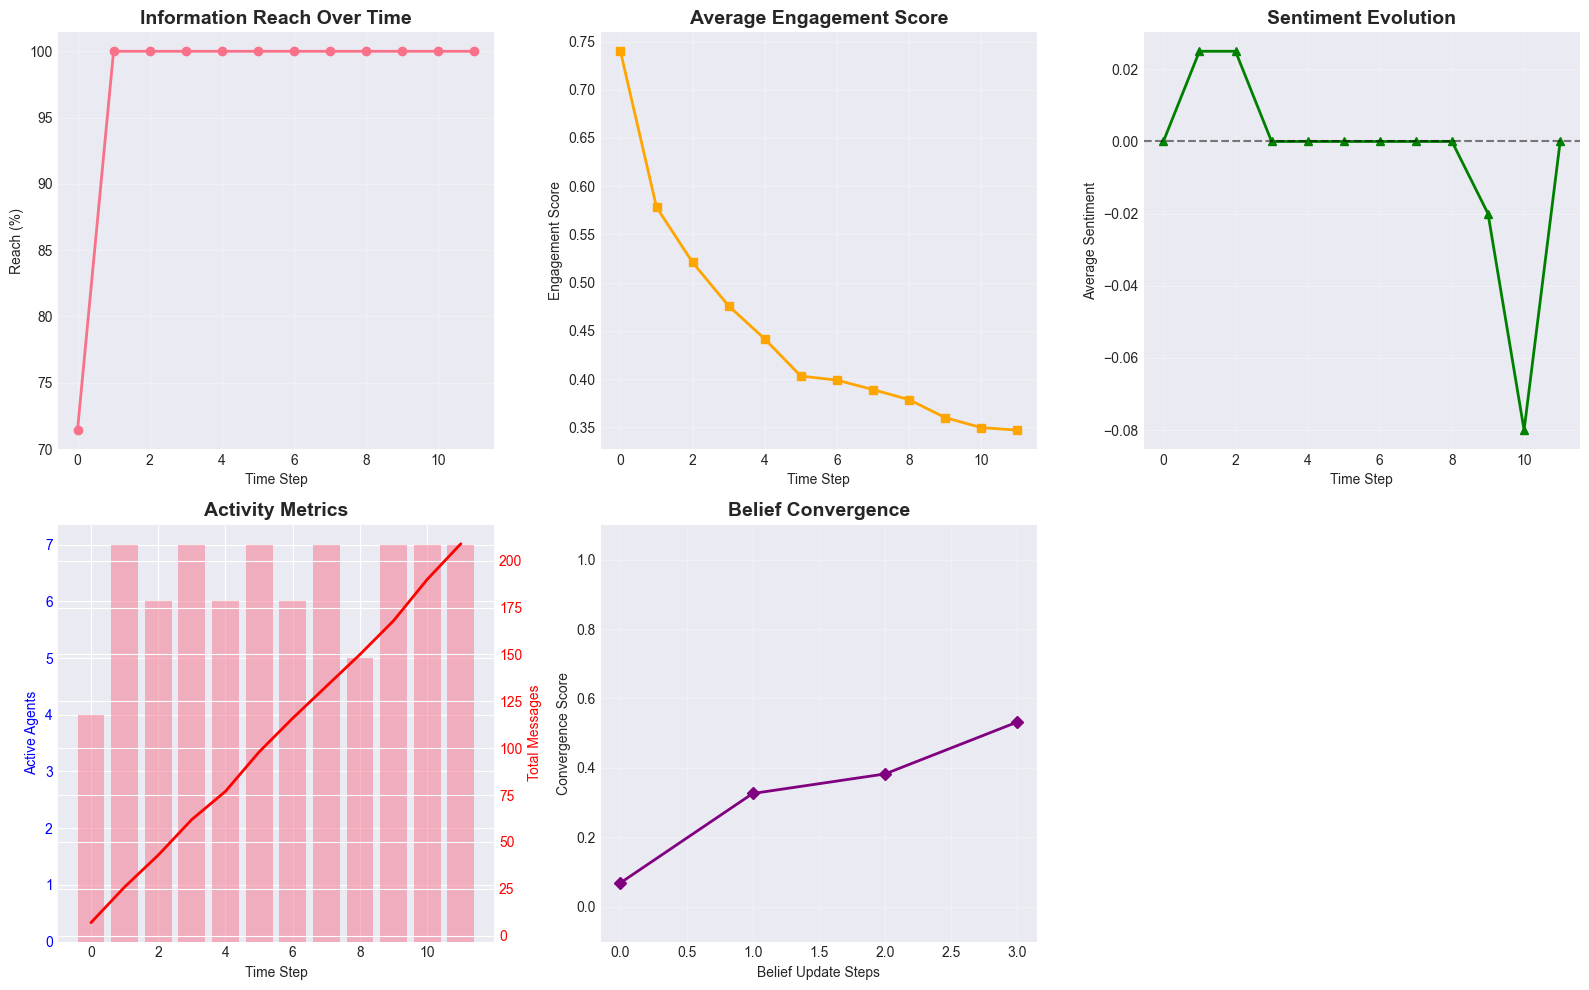

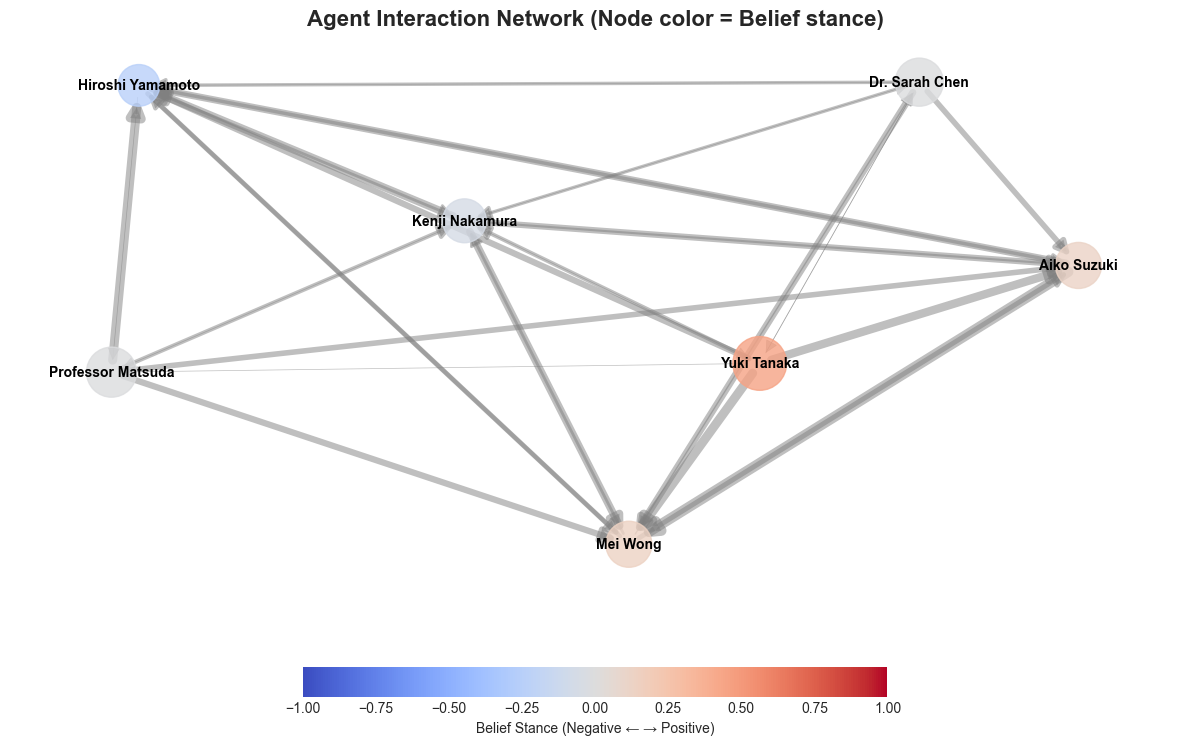

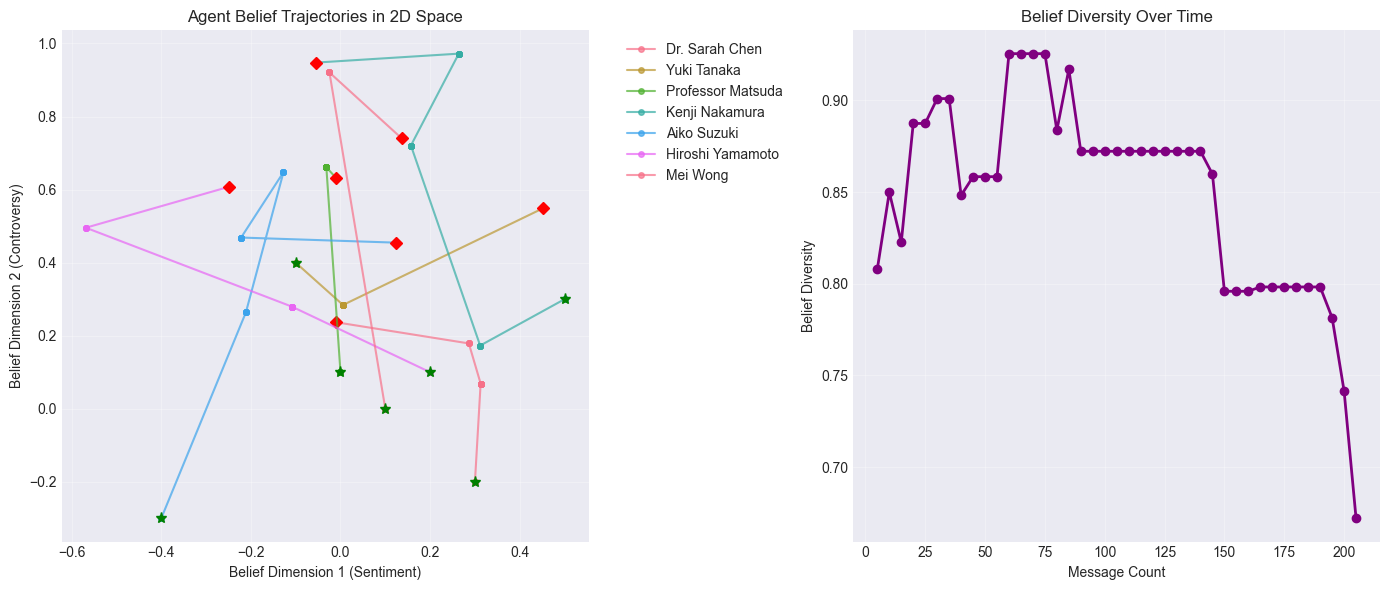

In [18]:
from datetime import timedelta

# Enhanced Configuration with API Management
class EnhancedConfig(Config):
    """Extended configuration with API quota management"""
    # API Management
    MAX_API_CALLS_PER_SIMULATION = 20  # Total API calls allowed
    API_RETRY_MAX_ATTEMPTS = 3  # Max retries per API call
    API_RETRY_BASE_DELAY = 2.0  # Base delay for exponential backoff
    API_CACHE_SIZE = 100  # Number of responses to cache
    
    # Smart API Usage
    USE_API_FOR_SEED_MESSAGES = True  # Always use API for initial seeds
    USE_API_FOR_HIGH_INFLUENCE_AGENTS = True  # Prioritize API for influential agents
    API_USAGE_DECAY_RATE = 0.8  # Reduce API usage over time
    MIN_API_USAGE_PROBABILITY = 0.2  # Minimum chance to use API
    
    # Response Quality Tiers
    TIER_1_INFLUENCE_THRESHOLD = 1.3  # High influence agents
    TIER_2_INFLUENCE_THRESHOLD = 1.0  # Medium influence agents


# API Call Manager
class APICallManager:
    """Manages API calls with quota tracking and smart fallback"""
    
    def __init__(self, max_calls: int = EnhancedConfig.MAX_API_CALLS_PER_SIMULATION):
        self.max_calls = max_calls
        self.calls_made = 0
        self.calls_failed = 0
        self.cache = {}  # Simple response cache
        self.last_429_time = None
        self.backoff_until = None
        
    def can_make_call(self) -> bool:
        """Check if we can make another API call"""
        if self.calls_made >= self.max_calls:
            return False
        
        # Check if we're in backoff period
        if self.backoff_until and datetime.now() < self.backoff_until:
            return False
            
        return True
    
    def should_use_api(self, agent_influence: float, time_step: int, is_seed: bool = False) -> bool:
        """Decide whether to use API based on context"""
        if not self.can_make_call():
            return False
            
        # Always try API for seed messages if configured
        if is_seed and EnhancedConfig.USE_API_FOR_SEED_MESSAGES:
            return True
        
        # Calculate API usage probability
        base_prob = 1.0
        
        # Decay API usage over time
        time_factor = EnhancedConfig.API_USAGE_DECAY_RATE ** (time_step / 3)
        base_prob *= max(time_factor, EnhancedConfig.MIN_API_USAGE_PROBABILITY)
        
        # Boost probability for high-influence agents
        if agent_influence >= EnhancedConfig.TIER_1_INFLUENCE_THRESHOLD:
            base_prob *= 1.5
        elif agent_influence >= EnhancedConfig.TIER_2_INFLUENCE_THRESHOLD:
            base_prob *= 1.2
        
        # Consider remaining quota
        quota_remaining = (self.max_calls - self.calls_made) / self.max_calls
        if quota_remaining < 0.2:  # Less than 20% quota remaining
            base_prob *= 0.5
        
        return random.random() < min(base_prob, 1.0)
    
    def record_call(self, success: bool):
        """Record API call result"""
        self.calls_made += 1
        if not success:
            self.calls_failed += 1
    
    def set_backoff(self, retry_attempt: int):
        """Set exponential backoff period"""
        delay = EnhancedConfig.API_RETRY_BASE_DELAY * (2 ** retry_attempt)
        self.backoff_until = datetime.now() + timedelta(seconds=delay)
        print(f"⏸️  API backoff: waiting {delay:.1f} seconds before next attempt")
    
    def get_cache_key(self, agent_name: str, topic: str, context_hash: str) -> str:
        """Generate cache key for response"""
        return f"{agent_name}:{topic}:{context_hash}"
    
    def get_cached_response(self, cache_key: str) -> Optional[str]:
        """Retrieve cached response if available"""
        return self.cache.get(cache_key)
    
    def cache_response(self, cache_key: str, response: str):
        """Cache a response"""
        if len(self.cache) >= EnhancedConfig.API_CACHE_SIZE:
            # Remove oldest entry (simple FIFO)
            oldest_key = next(iter(self.cache))
            del self.cache[oldest_key]
        self.cache[cache_key] = response
    
    def get_status(self) -> str:
        """Get current API usage status"""
        usage_percent = (self.calls_made / self.max_calls) * 100
        success_rate = ((self.calls_made - self.calls_failed) / self.calls_made * 100) if self.calls_made > 0 else 0
        return f"API Usage: {self.calls_made}/{self.max_calls} ({usage_percent:.1f}%) | Success Rate: {success_rate:.1f}%"


# Enhanced Agent with Smart API Usage
class SmartAPIAgent(Agent):
    """Agent with intelligent API usage and fallback"""
    
    api_manager = None  # Shared API manager across all agents
    
    @classmethod
    def set_api_manager(cls, manager: APICallManager):
        """Set the shared API manager"""
        cls.api_manager = manager
    
    def generate_response(self, context: Dict[str, any], topic: str, is_seed: bool = False) -> str:
        """Generate response with smart API usage"""
        
        # Check if we should use API
        if self.api_manager and self.api_manager.should_use_api(
            self.influence_score, 
            context.get('time_step', 0),
            is_seed
        ):
            # Try to get cached response first
            context_hash = self._generate_context_hash(context)
            cache_key = self.api_manager.get_cache_key(self.name, topic, context_hash)
            cached_response = self.api_manager.get_cached_response(cache_key)
            
            if cached_response:
                print(f"📦 [CACHED] {self.name}: Using cached response")
                return cached_response
            
            # Attempt API call with retry logic
            response = self._generate_api_response_with_retry(context, topic)
            
            if response:
                # Cache successful response
                self.api_manager.cache_response(cache_key, response)
                return response
        
        # Use enhanced fallback
        return self._generate_enhanced_fallback_response(topic, context)
    
    def _generate_api_response_with_retry(self, context: Dict[str, any], topic: str) -> Optional[str]:
        """Generate response using API with retry logic"""
        
        for attempt in range(EnhancedConfig.API_RETRY_MAX_ATTEMPTS):
            try:
                # Add delay to respect rate limits
                time.sleep(EnhancedConfig.API_DELAY)
                
                recent_messages = self._get_recent_messages(limit=5)
                belief_summary = self._summarize_belief()
                
                system_prompt = self._build_system_prompt(topic, belief_summary)
                user_prompt = self._build_user_prompt(context, recent_messages)
                
                if Config.API_PROVIDER == "openai":
                    if OPENAI_V1:
                        response = self.api_client.chat.completions.create(
                            model=Config.OPENAI_MODEL,
                            messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}
                            ],
                            max_tokens=Config.MAX_TOKENS,
                            temperature=0.8
                        )
                        result = response.choices[0].message.content.strip()
                    else:
                        response = openai.ChatCompletion.create(
                            model=Config.OPENAI_MODEL,
                            messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}
                            ],
                            max_tokens=Config.MAX_TOKENS,
                            temperature=0.8
                        )
                        result = response['choices'][0]['message']['content'].strip()
                
                # Success!
                self.api_manager.record_call(success=True)
                print(f"✅ [API] {self.name}: Generated response via API (attempt {attempt + 1})")
                return result
                
            except Exception as e:
                self.api_manager.record_call(success=False)
                
                if "429" in str(e) or "insufficient_quota" in str(e):
                    # Handle rate limit error
                    print(f"⚠️  [API] {self.name}: Rate limited (attempt {attempt + 1}/{EnhancedConfig.API_RETRY_MAX_ATTEMPTS})")
                    self.api_manager.set_backoff(attempt)
                    
                    # Wait for backoff period
                    if attempt < EnhancedConfig.API_RETRY_MAX_ATTEMPTS - 1:
                        backoff_delay = EnhancedConfig.API_RETRY_BASE_DELAY * (2 ** attempt)
                        time.sleep(backoff_delay)
                else:
                    # Other errors
                    print(f"❌ [API] {self.name}: API error - {str(e)[:100]}")
                    break
        
        # All attempts failed
        print(f"🔄 [FALLBACK] {self.name}: Using enhanced fallback after API failures")
        return None
    
    def _generate_context_hash(self, context: Dict) -> str:
        """Generate a hash of the context for caching"""
        # Simple hash based on key context elements
        key_elements = [
            context.get('current_event', ''),
            context.get('message_sentiment', 0),
            context.get('urgency', 'normal'),
            str(context.get('trending_topics', []))
        ]
        return str(hash(tuple(key_elements)))
    
    def _generate_enhanced_fallback_response(self, topic: str, context: Dict) -> str:
        """Enhanced fallback response generation"""
        # [Previous enhanced fallback implementation from earlier response]
        # This would include the rich, contextual responses based on role and belief state
        
        sentiment = float(self.belief.representation[0])
        controversy = float(self.belief.representation[1])
        certainty = float(self.belief.confidence)
        
        # Simplified version for space - would include full implementation
        base_responses = {
            "positive": f"Based on my analysis, {topic} shows significant promise for our objectives.",
            "negative": f"I have concerns about {topic} that we need to address carefully.",
            "neutral": f"We need more data on {topic} before reaching conclusions."
        }
        
        stance = "positive" if sentiment > 0.3 else "negative" if sentiment < -0.3 else "neutral"
        response = base_responses[stance]
        
        # Add role flavor
        if self.role == "Journalist":
            response += " The public deserves transparency on this matter."
        elif self.role == "Business Owner":
            response += " Small businesses need clarity on implementation."
        elif self.role == "Social Activist":
            response += " We must ensure no one is left behind."
        
        return response


# Modified run_full_simulation with API Management
def run_full_simulation_with_api_management():
    """Run simulation with intelligent API usage and quota management"""
    
    print("🚀 INITIALIZING CPC-BASED LLM AGENT SIMULATION (WITH SMART API USAGE)")
    print("=" * 70)
    
    # Initialize API manager
    api_manager = APICallManager()
    SmartAPIAgent.set_api_manager(api_manager)
    
    # Create agents using SmartAPIAgent class
    agents = []
    agent_configs = [
        ("Dr. Sarah Chen", "Policy Analyst", "Analytical, data-driven", ["economic policy", "fiscal responsibility"], 1.2),
        ("Yuki Tanaka", "Journalist", "Investigative, seeks transparency", ["current events", "public interest"], 1.5),
        ("Professor Matsuda", "Economics Professor", "Educational, theoretical", ["economic theory", "monetary policy"], 1.3),
        ("Kenji Nakamura", "Business Owner", "Practical, business-focused", ["business operations", "taxation"], 1.0),
        ("Aiko Suzuki", "Social Activist", "Passionate about justice", ["social welfare", "inequality"], 1.1),
        ("Hiroshi Yamamoto", "Financial Advisor", "Risk-aware, market-focused", ["investment", "risk management"], 0.9),
        ("Mei Wong", "International Trade Expert", "Global perspective", ["international trade", "global economics"], 1.1)
    ]
    
    for name, role, personality, knowledge, influence in agent_configs:
        agents.append(SmartAPIAgent(
            name=name,
            role=role,
            personality=personality,
            knowledge_base=knowledge,
            influence_score=influence
        ))
    
    # Initialize beliefs
    belief_inits = [
        torch.tensor([0.3, -0.2, 0.5, 0.1, -0.1, 0.2, 0.0, -0.3, 0.4, 0.2]),
        torch.tensor([-0.1, 0.4, 0.2, -0.3, 0.1, 0.0, -0.2, 0.3, -0.1, 0.2]),
        torch.tensor([0.0, 0.1, -0.1, 0.2, 0.3, -0.2, 0.1, 0.0, -0.1, 0.2]),
        torch.tensor([0.5, 0.3, -0.2, 0.1, 0.0, -0.1, 0.2, 0.4, -0.3, 0.1]),
        torch.tensor([-0.4, -0.3, 0.5, 0.2, -0.1, 0.3, -0.2, 0.1, 0.0, -0.1]),
        torch.tensor([0.2, 0.1, -0.3, 0.4, 0.2, -0.1, 0.0, 0.3, -0.2, 0.1]),
        torch.tensor([0.1, 0.0, 0.2, -0.1, 0.3, 0.1, -0.2, 0.0, 0.4, -0.3])
    ]
    
    for agent, belief_init in zip(agents, belief_inits):
        agent.belief.representation = belief_init
        agent.belief.confidence = torch.tensor(0.5 + 0.1 * agent.influence_score)
    
    # Set up connections
    for i, agent in enumerate(agents):
        possible = [a.name for j, a in enumerate(agents) if i != j]
        agent.connections = random.sample(possible, random.randint(2, 4))
    
    print(f"✅ Created {len(agents)} agents with smart API management")
    print(f"📊 API Budget: {api_manager.max_calls} calls")
    
    # Topics
    topics = [
        "Ministry of Finance fiscal policy announcement",
        "Economic stimulus measures",
        "Tax reform proposals",
        "Public spending priorities"
    ]
    
    # Initialize simulation with modified seed_information method
    class SmartSimulation(InformationDiffusionSimulation):
        def seed_information(self, topic: str, seed_agents: List[str], urgency: str = "normal"):
            """Modified to use is_seed flag"""
            initial_context = {
                "current_event": f"Breaking: New information about {topic}",
                "urgency": urgency,
                "time_step": 0,
                "trending_topics": [topic]
            }
            
            for agent_name in seed_agents:
                if agent_name in self.agents:
                    agent = self.agents[agent_name]
                    # Mark as seed message for priority API usage
                    response = agent.generate_response(initial_context, topic, is_seed=True)
                    
                    message = Message(
                        sender=agent.name,
                        content=response,
                        timestamp=datetime.now(),
                        topic=topic,
                        sentiment=self._analyze_sentiment_advanced(response),
                        engagement_score=random.uniform(0.7, 1.0) if urgency == "high" else random.uniform(0.4, 0.7),
                        recipients=["all"],
                        belief_vector=agent.belief.representation.clone()
                    )
                    
                    self.messages.append(message)
                    agent.memory.append(message)
                    self.observation_buffer.append((agent.name, message))
                    
                    self.interaction_network.nodes[agent.name]['messages_sent'] = 1
                    
                    print(f"🌱 [SEED] {agent.name}: {response}")
    
    # Create simulation
    sim = SmartSimulation(agents, topics)
    
    # Seed information
    print("\n🌱 SEEDING INITIAL INFORMATION")
    sim.seed_information(
        topic=topics[0],
        seed_agents=["Dr. Sarah Chen", "Yuki Tanaka"],
        urgency="high"
    )
    
    print("\n⏱️  RUNNING SIMULATION WITH SMART API USAGE")
    print("=" * 70)
    
    # Run simulation
    for step in range(12):
        print(f"\n--- Time Step {step + 1} ---")
        print(f"📊 {api_manager.get_status()}")
        
        # Update context with time step for API decision making
        sim.time_step = step
        sim.simulate_time_step()
        
        # Add secondary information
        if step == 5:
            print("\n🌱 INJECTING SECONDARY INFORMATION")
            sim.seed_information(
                topic=topics[1],
                seed_agents=["Professor Matsuda"],
                urgency="normal"
            )
    
    # Final status
    print(f"\n📊 FINAL API USAGE STATISTICS")
    print("=" * 50)
    print(f"{api_manager.get_status()}")
    print(f"Cache Hits: {len(api_manager.cache)} responses cached")
    
    # Generate report
    print("\n📊 GENERATING REPORT")
    report_df = sim.generate_report()
    
    # Visualizations
    print("\n📈 CREATING VISUALIZATIONS")
    sim.visualize_metrics()
    sim.visualize_network()
    sim.visualize_belief_evolution()
    
    return sim, report_df

# Replace the original run_full_simulation with this enhanced version
run_full_simulation = run_full_simulation_with_api_management
simulation, report = run_full_simulation()

## 9. CPC Theory Validation

Validate that the CPC implementation correctly follows the mathematical formulation.

🔬 VALIDATING CPC IMPLEMENTATION

1. Testing safety_prior_logprob:
   Shape: torch.Size([10])
   Sum of exp (should be ~1): 1.000000
   ✅ Valid probability distribution

2. Testing likelihood_logprob:
   Shape: torch.Size([10])
   Range: [-9.302, -4.558]
   ✅ Valid log likelihood values

3. Testing latent_prior_logprob:
   Value: -10.837
   ✅ Valid log probability

4. Testing full CPC posterior:
   Shape: torch.Size([10])
   Sum (should be 1): 1.000000
   Min/Max: [0.000059, 0.680034]
   ✅ Valid posterior distribution


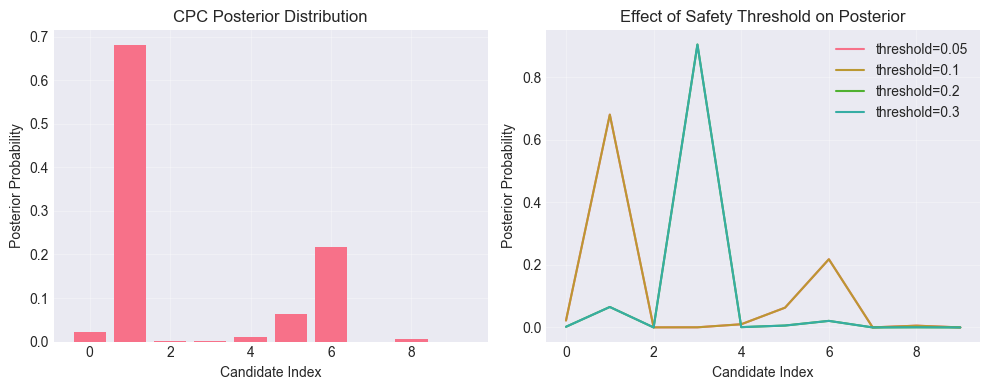


✅ CPC IMPLEMENTATION VALIDATED SUCCESSFULLY


In [20]:
def validate_cpc_implementation():
    """Validate CPC implementation with synthetic data"""
    print("🔬 VALIDATING CPC IMPLEMENTATION")
    print("=" * 50)
    
    # Create test data
    B, D, L = 10, Config.BELIEF_DIM, Config.LATENT_DIM
    w_candidates = torch.randn(B, D)
    
    # Create synthetic observations and parameters
    n_agents = 3
    observations = [torch.randn(D) for _ in range(n_agents)]
    latents = [torch.randn(L) for _ in range(n_agents)]
    thetas = [
        Theta(
            agent_id=f"agent_{i}",
            expertise_weights=torch.randn(D),
            confidence=0.5 + 0.1 * i,
            bias_vector=torch.randn(L) * 0.1
        )
        for i in range(n_agents)
    ]
    safety_cfg = SafetyConfig()
    
    # Test individual components
    print("\n1. Testing safety_prior_logprob:")
    log_prior = safety_prior_logprob(w_candidates, safety_cfg)
    print(f"   Shape: {log_prior.shape}")
    print(f"   Sum of exp (should be ~1): {torch.exp(log_prior).sum().item():.6f}")
    assert torch.allclose(torch.exp(log_prior).sum(), torch.tensor(1.0), atol=1e-5)
    print("   ✅ Valid probability distribution")
    
    print("\n2. Testing likelihood_logprob:")
    log_lik = likelihood_logprob(observations[0], w_candidates, latents[0])
    print(f"   Shape: {log_lik.shape}")
    print(f"   Range: [{log_lik.min().item():.3f}, {log_lik.max().item():.3f}]")
    print("   ✅ Valid log likelihood values")
    
    print("\n3. Testing latent_prior_logprob:")
    log_pz = latent_prior_logprob(latents[0], thetas[0])
    print(f"   Value: {log_pz.item():.3f}")
    print("   ✅ Valid log probability")
    
    print("\n4. Testing full CPC posterior:")
    posterior = cpc_posterior(w_candidates, observations, latents, thetas, safety_cfg)
    print(f"   Shape: {posterior.shape}")
    print(f"   Sum (should be 1): {posterior.sum().item():.6f}")
    print(f"   Min/Max: [{posterior.min().item():.6f}, {posterior.max().item():.6f}]")
    assert torch.allclose(posterior.sum(), torch.tensor(1.0), atol=1e-5)
    assert (posterior >= 0).all() and (posterior <= 1).all()
    print("   ✅ Valid posterior distribution")
    
    # Visualize posterior
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(B), posterior.numpy())
    plt.xlabel("Candidate Index")
    plt.ylabel("Posterior Probability")
    plt.title("CPC Posterior Distribution")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Show how posterior changes with safety threshold
    thresholds = [0.05, 0.1, 0.2, 0.3]
    for thresh in thresholds:
        safety_cfg.toxicity_threshold = thresh
        post = cpc_posterior(w_candidates, observations, latents, thetas, safety_cfg)
        plt.plot(post.numpy(), label=f"threshold={thresh}")
    plt.xlabel("Candidate Index")
    plt.ylabel("Posterior Probability")
    plt.title("Effect of Safety Threshold on Posterior")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ CPC IMPLEMENTATION VALIDATED SUCCESSFULLY")

# Run validation
validate_cpc_implementation()

## 10. Conclusions and Next Steps

### Summary

This notebook successfully implements a CPC theory-based belief update mechanism for LLM agents, strictly following the mathematical formulation:

$$P(w_d | O^{1:N}, S) = \prod_{k=1}^{N_h+N_a} P(o_d^k | w_d, z_d^k) P(z_d^k | \theta^k) P(w_d | S)$$

### Key Achievements

1. **Rigorous CPC Implementation**: 
   - Proper computation of safe priors P(w|S)
   - Likelihood calculation P(o|w,z)
   - Latent priors P(z|θ)
   - Correct normalization

2. **Integration with Agent Architecture**:
   - Each agent maintains belief state and parameters θ
   - Beliefs influence response generation
   - Regular consensus-based updates

3. **Enhanced Metrics**:
   - Belief convergence tracking
   - Belief-based response probability
   - Visualization of belief evolution

4. **Preserved Functionality**:
   - All original simulation features maintained
   - LLM integration unchanged
   - Network dynamics preserved

### Next Steps

To further enhance the CPC-based simulation:

1. **Refine Belief Representation**:
   - Learn optimal belief dimensions from data
   - Implement domain-specific belief structures

2. **Advanced Safety Constraints**:
   - Multi-dimensional safety criteria
   - Learned safety boundaries

3. **Empirical Validation**:
   - Compare with human consensus formation
   - Validate against real discussion data

4. **Scalability**:
   - Optimize for larger agent populations
   - Distributed belief computation

### Usage Notes

- Set API keys as environment variables before running
- Adjust `Config.BELIEF_UPDATE_FREQ` to control update frequency
- Use demo mode for testing without API calls
- Monitor belief convergence for consensus detection

This implementation provides a principled foundation for studying consensus formation in multi-agent systems with safety constraints.